# What Happened to Crime Activity in Seattle?

This is part 2 of a project I initially started as a means of finding a place to live. I ended up moving before finishing the project, but the data was interesting enough to motivate me to finish it. While the primary overall goal of this project is to determine the quality of life throughout Seattle, I have a few secondary goals for this part of the project:
<ol>
    <li>Find out how criminal activity has changed with time in Seattle
    <li>Find out how much each Seattle neighborhood has experienced criminal activity
    <li>Consolidate this new information with past information on code violations to figure out the best neighborhoods
</ol>

In this part, I will use data from my previous look at code violations in Seattle (in the time domain) as well as criminal activity data provided by [data.seattle.gov](data.seattle.gov). I will also use time series analysis methods I first encountered in [JTEST](TEst), and chloropleth creation code I encountered in [TEST](www.TEST.com)

## The Data

I use two data sets in part 2. The first contains 626557 logged [criminal cases](https://data.seattle.gov/Public-Safety/Seattle-Police-Department-Police-Report-Incident/7ais-f98f) around Seattle going back to 2007. The cases range from petty theft to homicide, and, if a case has more than one crime, it is logged multiple times. These are crimes that were called in by someone, responded to, and officially entered into the police records. Among other information, this set lists offense type, date, and location.
I use the output data from part I of this project

##The Analysis

Using the same methods as in the previous part, I will use Pandas, Matplotlib, and Numpy for most all of the analysis. Using timestamps from the crime data, I can make timeseries' that make certain types of analysis easier.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

crimes = pd.read_csv('../crimes2.csv', index_col='Date Reported', parse_dates=True)
violations = pd.read_csv('finalviolations.csv', sep=',', index_col=0, parse_dates=True)

Here are the headers for the crime data

In [2]:
list(crimes.columns)

['RMS CDW ID',
 'General Offense Number',
 'Offense Code',
 'Offense Code Extension',
 'Offense Type',
 'Summary Offense Code',
 'Summarized Offense Description',
 'Occurred Date or Date Range Start',
 'Occurred Date Range End',
 'Hundred Block Location',
 'District/Sector',
 'Zone/Beat',
 'Census Tract 2000',
 'Longitude',
 'Latitude',
 'Location',
 'Month',
 'Year']

and here are the newest/oldest entries in the database.

In [3]:
list(crimes.index)[0:10], list(crimes.index)[-11:-1]

([Timestamp('2015-08-26 12:37:00'),
  Timestamp('2015-08-26 10:27:00'),
  Timestamp('2015-08-26 10:15:00'),
  Timestamp('2015-08-26 08:48:00'),
  Timestamp('2015-08-26 08:29:00'),
  Timestamp('2015-08-26 08:25:00'),
  Timestamp('2015-08-26 07:56:00'),
  Timestamp('2015-08-26 06:49:00'),
  Timestamp('2015-08-26 05:01:00'),
  Timestamp('2015-08-26 03:40:00')],
 [Timestamp('2015-08-25 16:51:00'),
  Timestamp('2015-08-25 16:45:00'),
  Timestamp('2015-08-25 16:40:00'),
  Timestamp('2015-08-25 16:17:00'),
  Timestamp('2015-08-25 16:10:00'),
  Timestamp('2015-08-25 15:54:00'),
  Timestamp('2015-08-25 15:42:00'),
  Timestamp('2015-08-25 15:30:00'),
  Timestamp('2015-08-25 15:24:00'),
  Timestamp('2015-08-25 15:14:00')])

Now for some cleaning up. Turns out that there are a lot of entries that have only part of the information filled in, having either missing entries or have filler entries such as lat/longitude being set to zero. There is an outlier point from 1989 that is missing a significant chunk of information.

I'll strip away headers that I don't think are useful, e.g. we don't need 'location' if we have 'latitude' and 'longitude' (which end up being easier to work with anyway because 'location' is an array of tuples). Really, the things I care about are the types of offenses and where they happened.

In [4]:
crimes = crimes[['Summarized Offense Description','District/Sector', 'Zone/Beat', 'Latitude', 'Longitude']].dropna()
crimes = crimes[(crimes['Latitude'] != 0.0) & (crimes['Longitude'] != 0.0)]
crimes = crimes[crimes.index >= '2008-01-01']
crimes5yr = crimes[crimes.index >= '2011-01-01']

Here is a look at the different types of offenses listed in this dataset. The offense descriptions are sometimes in all caps or with the beginning letters capitalized, so I combine these with Pandas to avoid having separate listings.

In [5]:
crimes['Summarized Offense Description'].str.capitalize().value_counts()

Assault            7
Vehicle theft      7
Other property     4
Threats            4
Warrant arrest     4
Trespass           3
Dispute            3
Car prowl          3
Fraud              3
Narcotics          2
Property damage    2
Bike theft         2
Disturbance        1
Dui                1
Burglary           1
Robbery            1
Shoplifting        1
Name: Summarized Offense Description, dtype: int64

Now, the two main things I want to do with this data are: 1) Figure out how crimes are distributed throughout the city and 2) Figure out how crime has changed with time.

/home/ray/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=547.0, right=547.0
  'left=%s, right=%s') % (left, right))


count     1
mean     49
std     NaN
min      49
25%      49
50%      49
75%      49
max      49
Name: Date Reported, dtype: float64

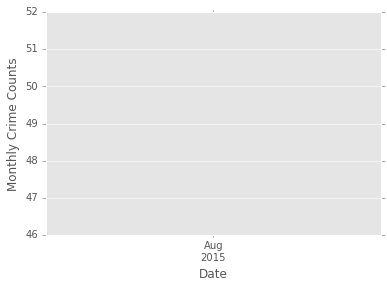

In [6]:
crime_counts = crimes.index.value_counts().resample('M', how='sum')
crime_counts['2008-01-01':].plot()
plt.xlabel('Date')
plt.ylabel('Monthly Crime Counts')

crime_counts.describe()

In [7]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

In [8]:
cases = pd.DataFrame({'Crime Counts': pd.Series(crime_counts, index=crime_counts.index),
                     'Daylight Hours': pd.Series(crime_counts.index.map(hours_of_daylight), index=crime_counts.index),
                     'Weekday': pd.Series(crime_counts.index.dayofweek, index=crime_counts.index)})
cases = cases.fillna(0)
cases = cases['2008-01-01':]

In [9]:
from sklearn.linear_model import LinearRegression

x = cases[['Daylight Hours','Weekday']]
y = cases['Crime Counts']
fit = LinearRegression().fit(x,y)

cases['Trend1'] = fit.predict(x)
cases['Detrended1'] = cases['Crime Counts'] - cases['Trend1'] + cases['Trend1'].mean()

/home/ray/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=547.0, right=547.0
  'left=%s, right=%s') % (left, right))


Detrended1     NaN
Crime Counts   NaN
dtype: float64

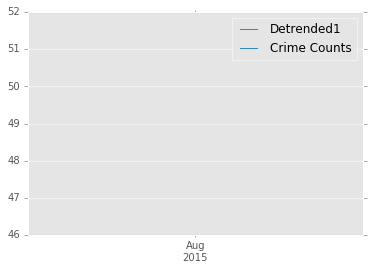

In [10]:
cases[['Detrended1','Crime Counts']].plot()
cases[['Detrended1','Crime Counts']].std()

/home/ray/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=547.0, right=547.0
  'left=%s, right=%s') % (left, right))


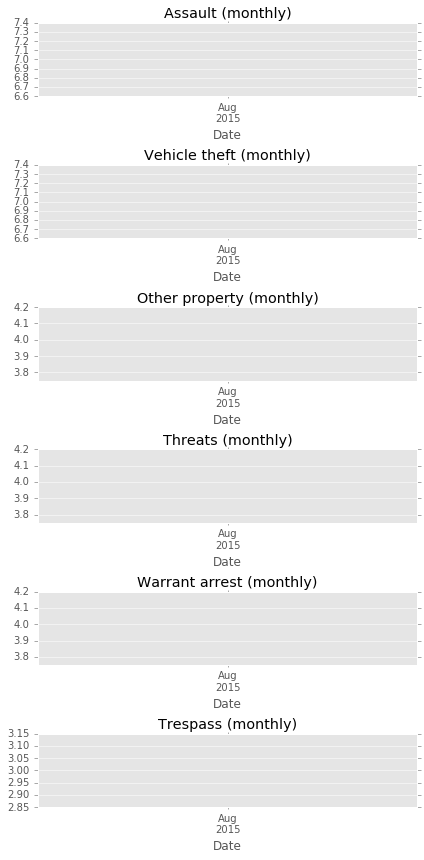

In [11]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(6,12))

descriptions = crimes['Summarized Offense Description'].str.capitalize()
offenses = [descriptions.value_counts().index[i] for i in range(6)]

for i in range(6):
    descriptions[descriptions == offenses[i]].index.value_counts().resample('M', how='sum').plot(ax=axes[i])
    axes[i].set_title(str(offenses[i]) + ' (monthly)')
    axes[i].set_xlabel('Date')
fig.tight_layout()

In [12]:
dist = crimes['District/Sector']
distN = crimes[(dist == 'B') | (dist == 'N') | (dist == 'L') | (dist == 'J') | (dist == 'U')]
distS = crimes[(dist == 'O') | (dist == 'R') | (dist == 'S')]
distE = crimes[(dist == 'E') | (dist == 'C') | (dist == 'G')]
distW = crimes[(dist == 'Q') | (dist == 'D') | (dist == 'M') | (dist == 'K')]
distSW = crimes[(dist == 'W') | (dist == 'F')]

In [13]:
dist_list = [distN, distS, distE, distW, distSW]
dist_str = ['North', 'South', 'East', 'West', 'Southwest']
for i in range(5):
    print(dist_str[i])
    print(dist_list[i]['Summarized Offense Description'].value_counts().head(5))
    print('\n')

North
VEHICLE THEFT    4
THREATS          2
FRAUD            1
ROBBERY          1
TRESPASS         1
Name: Summarized Offense Description, dtype: int64


South
ASSAULT           1
TRESPASS          1
BURGLARY          1
DUI               1
WARRANT ARREST    1
Name: Summarized Offense Description, dtype: int64


East
OTHER PROPERTY    2
ASSAULT           1
SHOPLIFTING       1
BIKE THEFT        1
FRAUD             1
Name: Summarized Offense Description, dtype: int64


West
ASSAULT           3
WARRANT ARREST    2
DISPUTE           2
CAR PROWL         2
TRESPASS          1
Name: Summarized Offense Description, dtype: int64


Southwest
ASSAULT            1
OTHER PROPERTY     1
VEHICLE THEFT      1
PROPERTY DAMAGE    1
THREATS            1
Name: Summarized Offense Description, dtype: int64




/home/ray/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=547.0, right=547.0
  'left=%s, right=%s') % (left, right))


East         0.000000
North        0.242061
South        0.000000
Southwest    0.000000
West         0.000000
dtype: float64

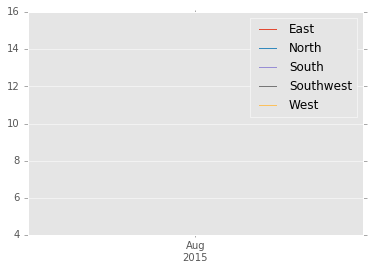

In [14]:
dist_tot = pd.DataFrame({'North': distN.index.value_counts(), 'South': distS.index.value_counts(),
                         'East': distE.index.value_counts(), 'West': distW.index.value_counts(),
                         'Southwest': distSW.index.value_counts()})

dist_tot['2008-01-01':].resample('M', how='sum').plot()
cases['South Counts'] = dist_tot['South'].index.value_counts().resample('M', how='sum')
dist_tot['2008-01-01':].std() / dist_tot['2008-01-01':].mean()

In [15]:
cases['Month Count'] = np.arange(len(cases))

headers = ['Daylight Hours', 'Weekday', 'South Counts', 'Month Count']

In [16]:
fit = LinearRegression().fit(cases[headers], cases['Crime Counts'])

cases['Trend3'] = fit.predict(cases[headers])
cases['Detrended3'] = cases['Crime Counts'] - cases['Trend3'] + cases['Trend3'].mean()

/home/ray/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=547.0, right=547.0
  'left=%s, right=%s') % (left, right))


Crime Counts   NaN
Detrended3     NaN
dtype: float64

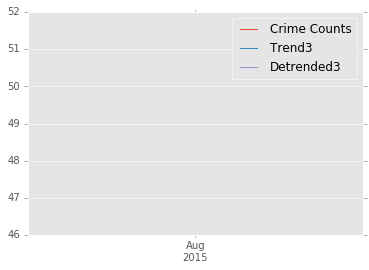

In [17]:
cases[['Crime Counts','Trend3','Detrended3']].plot()
cases[['Crime Counts','Detrended3']].std()

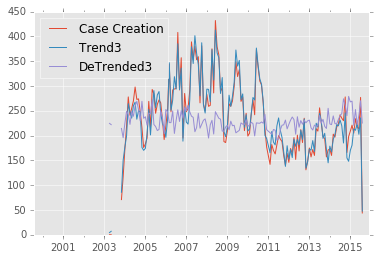

In [18]:
violations.resample('M',how='sum')[['Case Creation','Trend3','DeTrended3']].plot()

In [19]:
code_violations = pd.read_csv('../code-violations-seattle/violations.csv', header=0, index_col='Date Case Created')
code_density = code_violations[np.isfinite(code_violations['Longitude']) & np.isfinite(code_violations['Latitude'])]

crime_density = crimes[np.isfinite(crimes['Longitude']) & np.isfinite(crimes['Latitude'])]
crime_density = crime_density[crime_density['Longitude'] > -123.0]

KeyboardInterrupt: 

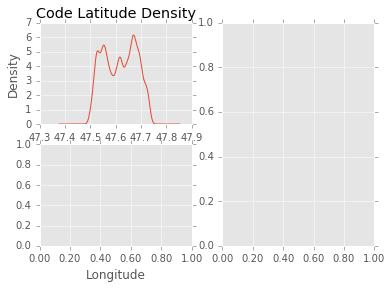

In [20]:
axes1 = plt.subplot2grid((2,2),(0,0))
axes2 = plt.subplot2grid((2,2),(1,0))
axes3 = plt.subplot2grid((2,2),(0,1), rowspan=2)
axes2.xaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))
axes3.xaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))

axes1.set_xlabel('Latitude')
axes2.set_xlabel('Longitude')

code_density['Latitude'].plot(ax=axes1, kind='kde', title='Code Latitude Density')
code_density['Longitude'].plot(ax=axes2, kind='kde', title='Code Longitude Density')
code_density.plot(ax=axes3, kind='hexbin', x='Longitude', y='Latitude', gridsize=60, title='Code Violation Density')

plt.tight_layout()

In [ ]:
axes1 = plt.subplot2grid((2,2),(0,0))
axes2 = plt.subplot2grid((2,2),(1,0))
axes3 = plt.subplot2grid((2,2),(0,1), rowspan=2)
axes2.xaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))
axes3.xaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))

axes1.set_xlabel('Latitude')
axes2.set_xlabel('Longitude')

crime_density['Latitude'].plot(ax=axes1, kind='kde', title='Crime Latitude Density')
crime_density['Longitude'].plot(ax=axes2, kind='kde', title='Crime Longitude Density')
crime_density.plot(ax=axes3, kind='hexbin', x='Longitude', y='Latitude', gridsize=60, title='Crime Density')

plt.tight_layout()

In [ ]:
import fiona

In [ ]:
shapefilename ='Neighborhoods/WGS84/Neighborhoods'
shp = fiona.open(shapefilename+'.shp')
coords = shp.bounds
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01

In [ ]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([coords[0], coords[2]]),
    lat_0=np.mean([coords[1], coords[3]]),
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - (extra * h), 
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + (extra * h),
    resolution='i',  suppress_ticks=True)

_out = m.readshapefile(shapefilename, name='seattle', drawbounds=False, color='none', zorder=2)

In [ ]:
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

df_map = pd.DataFrame({
    'poly': [Polygon(hood_points) for hood_points in m.seattle],
    'name': [hood['S_HOOD'] for hood in m.seattle_info]
})

In [ ]:
mapped_points = [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(crimes['Longitude'], 
            crimes['Latitude'])]
all_points = MultiPoint(mapped_points)

mapped_points5yr = [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(crimes5yr['Longitude'], 
            crimes5yr['Latitude'])]
all_points5yr = MultiPoint(mapped_points5yr)

hood_polygons = prep(MultiPolygon(list(df_map['poly'].values)))

In [ ]:
city_points = [i for i in all_points if hood_polygons.contains(i)]
city_points5yr = [i for i in all_points5yr if hood_polygons.contains(i)]

In [ ]:
def num_of_contained_points(apolygon, city_points):
    contained = [i for i in city_points if prep(apolygon).contains(i)]
    
    return int(len(contained))

df_map['hood_count'] = df_map['poly'].apply(num_of_contained_points, args=(city_points,))
df_map['hood_count5yr'] = df_map['poly'].apply(num_of_contained_points, args=(city_points5yr,))

In [ ]:
import colormaps as cmaps
plt.register_cmap(name='viridis', cmap=cmaps.viridis)

In [ ]:
def self_categorize(entry, breaks):
    for i in range(len(breaks)-1):
        if entry > breaks[i] and entry <= breaks[i+1]:
            return i
    return -1

def custom_colorbar(cmap, **kwargs):    
    from matplotlib.colors import BoundaryNorm
    from matplotlib.cm import ScalarMappable
    import matplotlib.colors as mplc
    
    norm = mplc.Normalize(vmin=0., vmax=40000.)
    mappable = ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array([])
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_label('Recorded Criminal Cases')
    return colorbar

In [ ]:
#Create patches for each neighborhood
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
df_map['patches5yr'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.8, alpha=1., zorder=4))
pc5yr = PatchCollection(df_map['patches5yr'], match_original=True)

In [ ]:
#Create colormap & set patch color
cmap = plt.get_cmap('viridis')

hood_norm = (df_map.hood_count.values - df_map.hood_count.values.min())/(
                  df_map.hood_count.values.max()-df_map.hood_count.values.min())
cmap_list = [cmap(val) for val in hood_norm]
pc.set_facecolor(cmap_list)

#Create figure, plot patch collection
figwidth = 10
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='#555555', frame_on=False)
ax.add_collection(pc)

#Draw a map scale
m.drawmapscale(coords[0]+0.11, coords[1],
    coords[2], coords[3], 5.,
    units='km', fontsize=16, barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
    zorder=5)

#Create colorbar
cbar = custom_colorbar(cmap, shrink=0.5)
cbar.ax.tick_params(labelsize=10)

fig.suptitle("Criminal Activity in Seattle Neighborhoods", fontdict={'size':18, 'fontweight':'bold'}, y=0.935)
ax.set_title("Using all recorded criminal cases since 2008", fontsize=10, y=0.995)
plt.savefig('allcrimes.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')

In [ ]:
#Create colormap & set patch color
hood_norm5yr = (df_map.hood_count5yr.values - df_map.hood_count5yr.values.min())/(
                  df_map.hood_count5yr.values.max()-df_map.hood_count5yr.values.min())
cmap_list = [cmap(val) for val in hood_norm5yr]
pc5yr.set_facecolor(cmap_list)

#Create figure, plot patch collection
figwidth = 10
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='#555555', frame_on=False)
ax.add_collection(pc5yr)

#Draw a map scale
m.drawmapscale(coords[0]+0.11, coords[1],
    coords[2], coords[3], 5.,
    units='km', fontsize=16, barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
    zorder=5)

#Create colorbar
cbar = custom_colorbar(cmap, shrink=0.5)
cbar.ax.tick_params(labelsize=10)

fig.suptitle("Criminal Activity in Seattle Neighborhoods", fontdict={'size':18, 'fontweight':'bold'}, y=0.935)
ax.set_title("Using all recorded criminal cases since 2008", fontsize=10, y=0.995)
plt.savefig('allcrimes2.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')

In [ ]:
import choropleth as ch

In [ ]:
cmap = plt.get_cmap('viridis')
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'

boundaries = ch.open_shape(shapefilename)
pc, hood_norm, m = ch.create_patches(shapefilename, crimes['Latitude'], 
                                                    crimes['Longitude'], boundaries)
pc = ch.set_patchcolor(pc, cmap, hood_norm)

figwidth = 10
title = 'Criminal Activity in Seattle Neighborhoods'
suptitle = 'test'
savename = 'test.png'
ch.plotter(pc, m, boundaries, cmap, figwidth, title, suptitle, savename)

In [ ]:
cmap = plt.get_cmap('viridis')
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'

boundaries = ch.open_shape(shapefilename)
pc, hood_norm, m = ch.create_patches(shapefilename, crimes['Latitude'], 
                                                    crimes['Longitude'], boundaries)
pc = ch.set_patchcolor(pc, cmap, hood_norm)

figwidth = 10
title = 'Criminal Activity in Seattle Neighborhoods'
suptitle = 'test'
savename = 'test.png'
ch.plotter(pc, m, boundaries, cmap, figwidth, title, suptitle, savename)